In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [7]:
import os

base_dir = os.getcwd()
dataset_path = os.path.join(base_dir, 'Dataset', 'Mendely_4_Disease_Dataset')

dataset = tf.keras.preprocessing.image_dataset_from_directory( # Generates a tf.data.Dataset from image files in a directory.
    dataset_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5932 files belonging to 4 classes.


In [4]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
class_names = dataset.class_names
class_names

['Blast', 'Blight', 'Brownspot', 'Tungro']

In [6]:
len(dataset) # This is 18 because each element in the tf dataset is a batch [32 * 18 = 576]

186

In [7]:
# Printing the images of with respect to each batch and with each and every pixel of an image in a batch (Hex values)
for data in dataset:
  print(data)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[164.31697   , 165.9509    , 159.7924    ],
         [155.77094   , 158.37807   , 147.35352   ],
         [146.08664   , 148.56915   , 127.8571    ],
         ...,
         [ 64.69927   , 125.45857   ,  23.479055  ],
         [ 33.820843  ,  92.79405   ,   2.6195498 ],
         [ 46.36607   , 104.36607   ,  19.366072  ]],

        [[136.04688   , 144.85045   , 136.4241    ],
         [157.01225   , 166.78903   , 153.49663   ],
         [164.21494   , 173.51738   , 150.53746   ],
         ...,
         [ 60.0804    , 120.94419   ,  20.868374  ],
         [ 34.298515  ,  93.27172   ,   1.8965096 ],
         [ 41.57366   ,  99.57366   ,  13.622767  ]],

        [[107.75446   , 126.30134   , 114.716515  ],
         [119.324425  , 138.84451   , 122.393616  ],
         [122.65394   , 141.44377   , 116.81946   ],
         ...,
         [ 45.43349   , 107.29955   ,   6.958296  ],
         [ 27.714678  ,  86.68788   ,   0.4221

(32, 224, 224, 3)
[1 1 3 3 0 0 3 1 3 2 0 3 2 3 0 2 1 2 0 0 3 0 0 3 3 1 0 1 3 1 2 1]
(224, 224, 3)


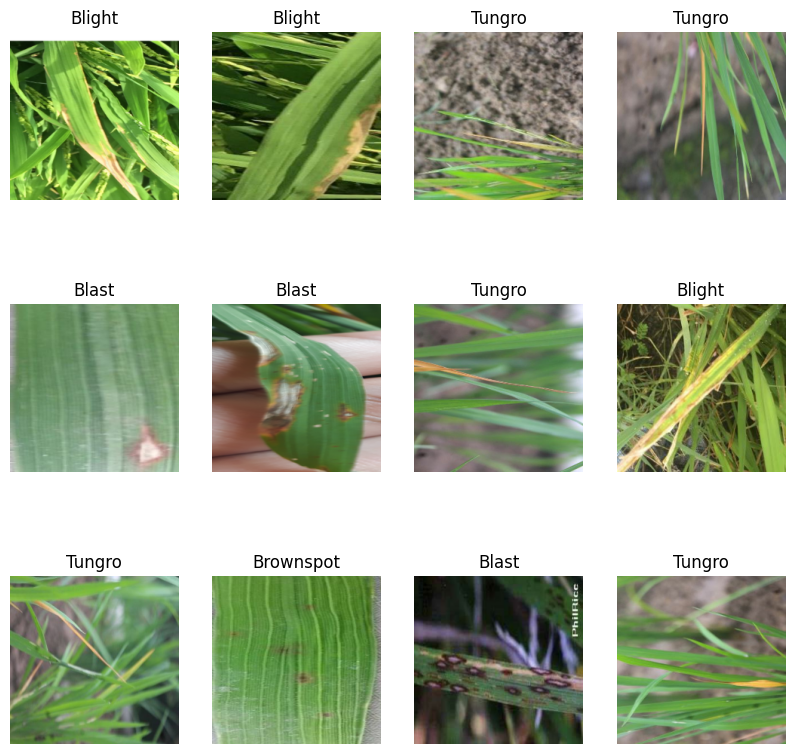

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1): # Gives only 1 batch
  print(image_batch.shape),
  print(label_batch.numpy()),
  print(image_batch[0].shape), # shape of first image in the batch
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8")) # without mentioning "astype("unit8")" it assumes float value
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

# Splitting Dataset

80% ==> training
20% ==> 10% validation, 10% test

In [9]:
len(dataset)

186

In [10]:
train_size = 0.8
len(dataset)*train_size # 80% of dataset i.e. 80% of 18 = 14.44

148.8

In [11]:
train_ds = dataset.take(14) # similar to train_test_split of sklearn
len(train_ds)

14

In [12]:
test_ds = dataset.skip(14) #start after 14 i.e 14 to 18 for test and validation set [Temp test Dataset]
len(test_ds) 

172

In [13]:
val_size = 0.1
len(dataset)*val_size

18.6

In [14]:
val_ds = test_ds.take(2) # validation Dataset
len(val_ds)

2

In [15]:
test_ds = test_ds.skip(2) # Actual Test Dataset
len(test_ds)

170

In [16]:
#same thing as before but in one function
def get_dataset_partitions_tf(ds, train_split =0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=500):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
print(len(train_ds), len(val_ds), len(test_ds))

148 18 20


In [19]:
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE) # Let tensorflow decide the number of batches to be used for loading
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE) # Let tensorflow decide the number of batches to be used for loading
test_ds = test_ds.cache().shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE) # Let tensorflow decide the number of batches to be used for loading

Pre Processing Pipeline, Scaling etc

In [20]:
# Pre Processing Pipeline, Scaling etc
# One layer called resize_and_rescale layer
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Model Building:

In [22]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)), # 2D Convolutional layer
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), # Dense Layer of 64 Neurons
    layers.Dense(4, activation='softmax') # softmax:Normalise probablity of classes (4 classes)
])

model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

Compiling Model
Optimizer = adam

SparseCategoricalCrossentropy for losses

accuracy as a metric

In [24]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50


2023-03-08 02:05:03.488364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-08 02:05:04.862435: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f96f00040f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 02:05:04.862530: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-03-08 02:05:04.879535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-08 02:05:04.882620: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-03-08 02:05:05.038499: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once 

148/148 [==============================] - 31s 131ms/step - loss: 1.1314 - accuracy: 0.4758 - val_loss: 0.9300 - val_accuracy: 0.6424
Epoch 2/50
148/148 [==============================] - 15s 99ms/step - loss: 0.8258 - accuracy: 0.6735 - val_loss: 0.7252 - val_accuracy: 0.7031
Epoch 3/50
148/148 [==============================] - 16s 109ms/step - loss: 0.6490 - accuracy: 0.7470 - val_loss: 0.6980 - val_accuracy: 0.7622
Epoch 4/50
148/148 [==============================] - 15s 102ms/step - loss: 0.4888 - accuracy: 0.8123 - val_loss: 0.3648 - val_accuracy: 0.8785
Epoch 5/50
148/148 [==============================] - 15s 104ms/step - loss: 0.4190 - accuracy: 0.8399 - val_loss: 0.3347 - val_accuracy: 0.8837
Epoch 6/50
148/148 [==============================] - 16s 106ms/step - loss: 0.2783 - accuracy: 0.8961 - val_loss: 0.2062 - val_accuracy: 0.9340
Epoch 7/50
148/148 [==============================] - 16s 111ms/step - loss: 0.2038 - accuracy: 0.9319 - val_loss: 0.1900 - val_accuracy: 0.92

In [ ]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 2s 20ms/step - loss: 1.0180e-04 - accuracy: 1.0000


Plotting/Analysing Results

In [ ]:
print(history.params)
history.history.keys()

{'verbose': 1, 'epochs': 50, 'steps': 148}


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

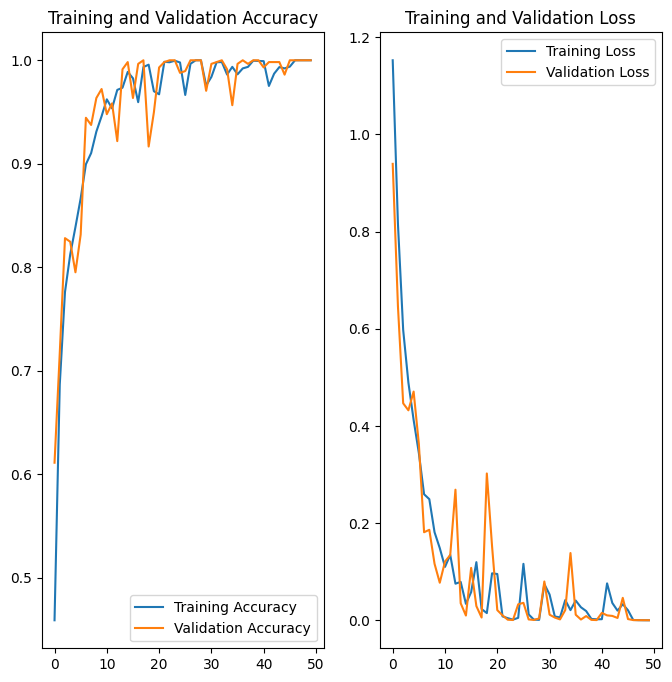

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tungro
1/1 [==============================] - 0s 113ms/step
[2.8383312e-08 4.1945260e-08 4.9298232e-10 9.9999988e-01]
predicted label: Tungro


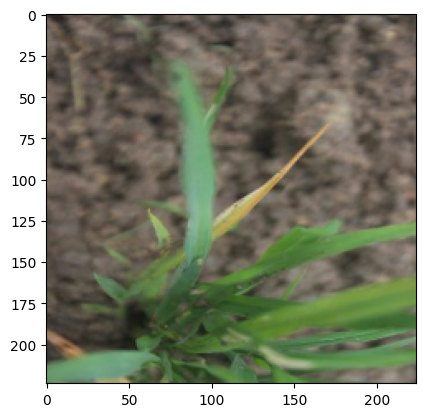

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch) # Prediction of whole batch
    print(batch_prediction[0]) # Now the predicted class is the element in the array with the highest value, so take numpy.argmax and print the index of the array
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]) # Prediction for the first image of the batch. Classname of respective index predicted



In [ ]:
# Function that takes model and image as an input and outputs confidence
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions)),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step
[[[ 78.823425  89.823425  33.82342 ]
  [ 76.35722   87.35722   31.357224]
  [ 69.98525   80.98525   24.98525 ]
  ...
  [169.16965  176.16965  124.16964 ]
  [168.59525  176.08633  124.57742 ]
  [168.68948  176.68948  125.68949 ]]

 [[ 63.06553   73.5566    19.083387]
  [ 64.43782   74.66988   19.678652]
  [ 64.12851   74.11065   18.61958 ]
  ...
  [170.86336  178.01785  125.940605]
  [169.01782  177.02692  125.259   ]
  [167.15482  175.15482  124.15482 ]]

 [[ 55.082428  64.234215  11.234216]
  [ 60.110252  69.18479   15.166932]
  [ 65.72609   74.72609   19.726086]
  ...
  [171.69641  180.43892  127.567665]
  [168.60127  177.11018  125.09236 ]
  [165.49107  173.49107  122.49108 ]]

 ...

 [[157.16965  138.62503   80.47323 ]
  [158.       139.45538   81.30359 ]
  [156.30357  137.75896   79.60716 ]
  ...
  [137.78201  122.154724  59.979893]
  [139.77187  124.30721   62.078167]
  [140.49535  125.17707   62.89923 ]]

 [[157.66074  142.1518

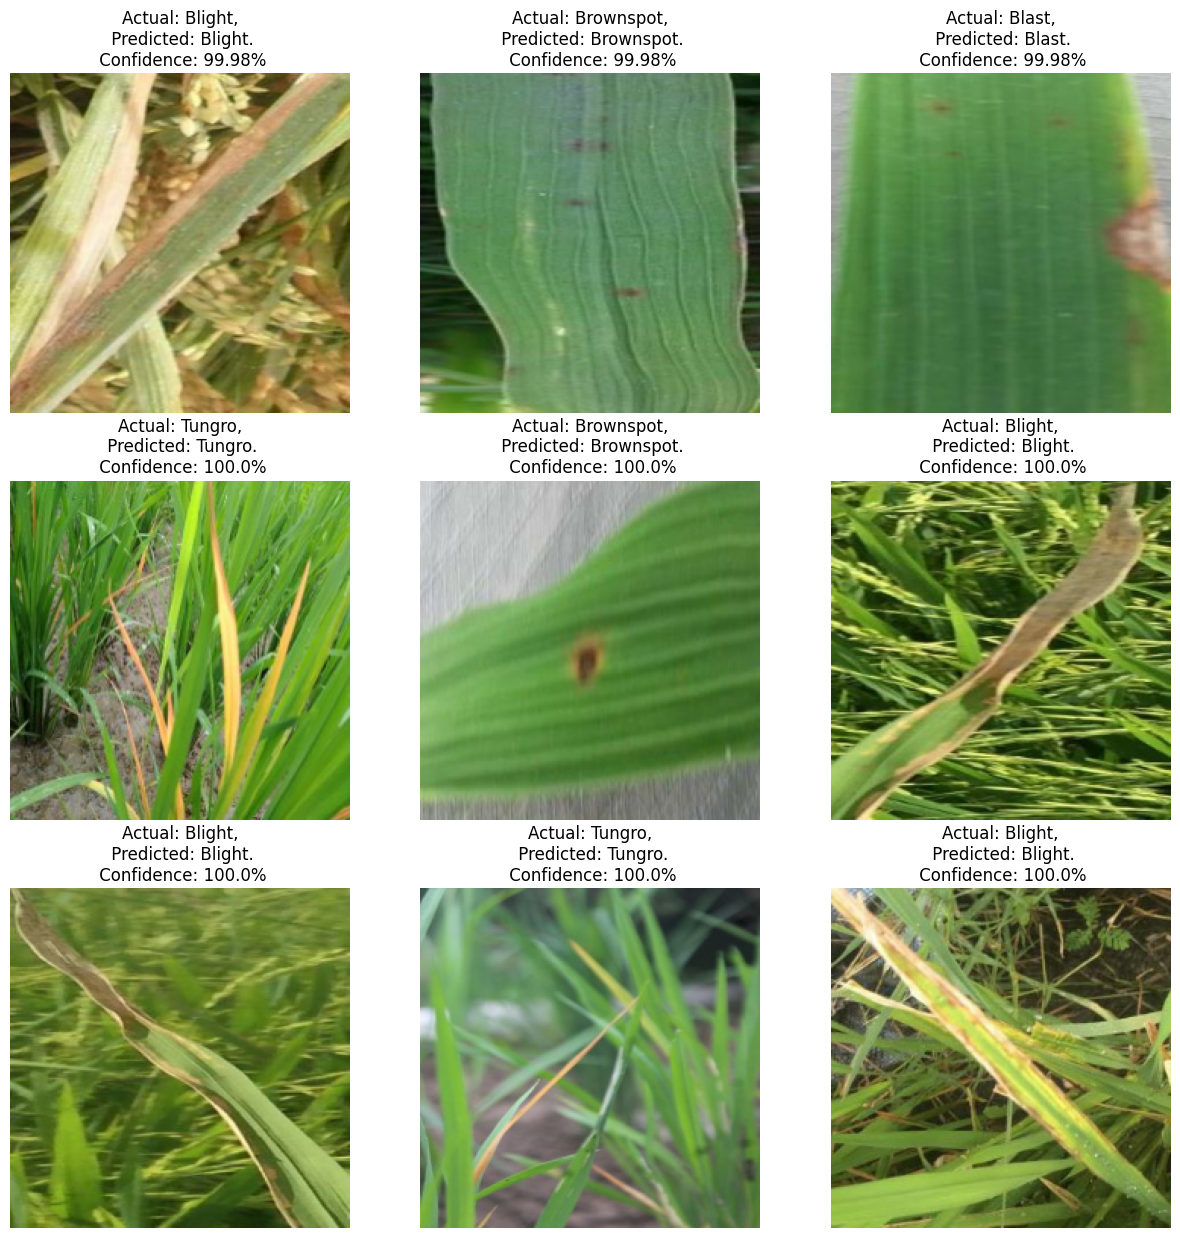

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        print(images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [ ]:
# import os
# model_version = "4_disease_classes_Mendeley.h5"
# base_dir = os.getcwd()
# dataset_path = os.path.join(base_dir, 'models', model_version)
# model.save(dataset_path)